#CS-412 Intro to Machine Learning
##Final Project
Name: Uday Bhaskar Voora

UIN: 655437573


Link to the dataset: [Click here](https://www.kaggle.com/datasets/aguado/telemarketing-jyb-dataset?select=train.csv)

In [55]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt



In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [57]:
# Load dataset
df = pd.read_csv("/content/gdrive/My Drive/412/project/bank-full.csv",delimiter=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [58]:

# Binary encoding for 'y', 'loan', 'housing', 'default'
binary_cols = ['y', 'loan', 'housing', 'default']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# Ordinal encoding for 'education' and 'poutcome'
education_order = ['unknown', 'primary', 'secondary', 'tertiary']
poutcome_order = ['unknown', 'failure', 'other', 'success']
ord_enc = OrdinalEncoder(categories=[education_order, poutcome_order], handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
df[['education', 'poutcome']] = ord_enc.fit_transform(df[['education', 'poutcome']])

# One-hot encoding for nominal variables
nominal_cols = ['job', 'marital', 'contact', 'month']
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# eature scaling (MinMax) for numerical features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('y')  # exclude target
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 6. Split into features and target
y = df['y']
X = df.drop(columns=['y'])

# 7. Balance dataset: SMOTE oversampling then RandomUnderSampler
target_counts = y.value_counts()
print(f"Original distribution:\n{target_counts}\n")

smote = SMOTE(sampling_strategy=1.0, random_state=42)  # minority up to equal
X_res, y_res = smote.fit_resample(X, y)

rus = RandomUnderSampler(sampling_strategy={0: 15000}, random_state=42)
X_bal, y_bal = rus.fit_resample(X_res, y_res)

print(f"After balancing:\n{y_bal.value_counts()}\n")


Original distribution:
y
0    39922
1     5289
Name: count, dtype: int64

After balancing:
y
1    39922
0    15000
Name: count, dtype: int64



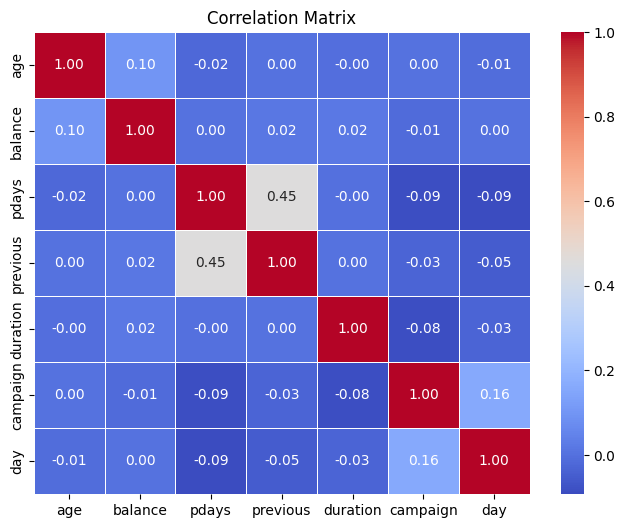

In [59]:
# Select the relevant columns for correlation
selected_columns = ['age', 'balance', 'pdays', 'previous','duration','campaign','day']

# Compute the correlation matrix for the selected variables
corr_matrix = df[selected_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the size to fit the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Adding a title to the plot
plt.title('Correlation Matrix')

# Show the plot
plt.show()


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Split the balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# Now proceed with the model training and hyperparameter tuning as before
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Neural Network': MLPClassifier(max_iter=200)
}

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 5],
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 5],
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(32, 32), (64, 64)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'learning_rate_init': [0.001, 0.01]
    }
}

# Dictionary to store best models
best_models = {}

# Train each model and perform hyperparameter tuning using GridSearchCV
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Set up the grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=3, n_jobs=-1)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_models[model_name] = grid_search.best_estimator_

    # Print the best hyperparameters for the current model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

# Evaluate the models
for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    print(f"{model_name} - Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print('-' * 50)


Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Random Forest...
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Training SVM...
Best parameters for SVM: {'C': 10, 'degree': 2, 'kernel': 'rbf'}
Training Neural Network...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for Neural Network: {'activation': 'tanh', 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.001, 'solver': 'adam'}
Evaluating Logistic Regression...
Logistic Regression - Accuracy: 0.8900318616294948
              precision    recall  f1-score   support

           0       0.85      0.73      0.79      3042
           1       0.90      0.95      0.93      7943

    accuracy                           0.89     10985
   macro avg       0.88      0.84      0.86     10985
weighted avg       0.89      0.89      0.89     10985

--------------------------------------------------
Evaluating Decision Tree...
Decision Tree - Accuracy: 0.914792899408284
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3042
           1       0.93      0.95      0.94      7943

    accuracy                           0.91     10985
   macro avg       0.90      0.89      0.89     10985
weighted avg       0.91      0.91      0.91     10985



In [74]:
#Subsample
n_samples = 40000
if len(X_bal) > n_samples:
    rng = np.random.RandomState(42)
    idx = rng.choice(X_bal.shape[0], size=n_samples, replace=False)
    X_bal_sub = X_bal.iloc[idx]
    y_bal_sub = y_bal.iloc[idx]
    print(f"Using subsample of {n_samples} samples (out of {len(X_bal)})")
else:
    X_bal_sub, y_bal_sub = X_bal, y_bal

# Split the subsample
X_train, X_test, y_train, y_test = train_test_split(
    X_bal_sub, y_bal_sub, test_size=0.2, random_state=42
)

Using subsample of 40000 samples (out of 54922)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network → best params: {'activation': 'tanh', 'hidden_layer_sizes': (32, 32), 'learning_rate_init': 0.001, 'solver': 'adam'}, CV acc: 0.901
Random Forest → best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}, CV acc: 0.920
SVM → best params: {'C': 10, 'kernel': 'rbf'}, CV acc: 0.901

Neural Network classification report:

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       535
           1       0.92      0.95      0.93      1465

    accuracy                           0.90      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.90      0.90      0.90      2000


Random Forest classification report:

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       535
           1       0.92      0.98      0.95      1465

    accuracy                           0.92      2000
   macro avg       0.93      0.87      0.90      2000
weighte

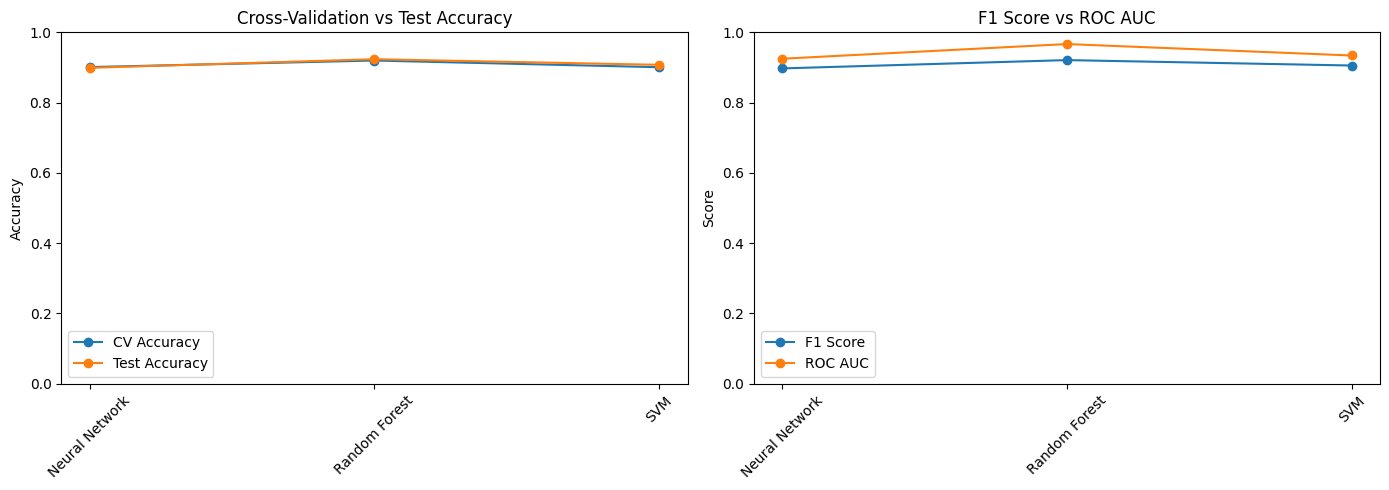

In [62]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)
param_grid_nn = {
    'hidden_layer_sizes': [(32, 32), (64, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01]
}
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# GridSearchCV each model & record CV accuracy
grids = {
    'Neural Network': (MLPClassifier(max_iter=500), param_grid_nn),
    'Random Forest':   (RandomForestClassifier(),    param_grid_rf),
    'SVM':             (SVC(probability=True),       param_grid_svm)
}

best_estimators = {}
cv_scores = {}
for name, (model, grid) in grids.items():
    gs = GridSearchCV(model, grid, cv=3, n_jobs=-1, scoring='accuracy')
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_
    cv_scores[name] = gs.best_score_
    print(f"{name} → best params: {gs.best_params_}, CV acc: {gs.best_score_:.3f}")

# Evaluate on test set
results = []
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    res = {
        'model':    name,
        'cv_acc':   cv_scores[name],
        'test_acc': accuracy_score(y_test, y_pred),
        'precision':precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall':   recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1':       f1_score(y_test, y_pred, average='weighted', zero_division=0),
    }
    if hasattr(model, "predict_proba"):
        res['roc_auc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"\n{name} classification report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    results.append(res)

# Tabulat the reuslts
df_results = pd.DataFrame(results).set_index('model')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Leftside CV vs Test Accuracy
axes[0].plot(df_results.index, df_results['cv_acc'],  marker='o', label='CV Accuracy')
axes[0].plot(df_results.index, df_results['test_acc'], marker='o', label='Test Accuracy')
axes[0].set_title('Cross-Validation vs Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Rightside F1 Score vs ROC AUC
axes[1].plot(df_results.index, df_results['f1'],      marker='o', label='F1 Score')
axes[1].plot(df_results.index, df_results['roc_auc'], marker='o', label='ROC AUC')
axes[1].set_title('F1 Score vs ROC AUC')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5822 - loss: 1.9580 - val_accuracy: 0.7256 - val_loss: 1.7120 - learning_rate: 1.0000e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6182 - loss: 1.7879 - val_accuracy: 0.7337 - val_loss: 1.6111 - learning_rate: 1.0000e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6564 - loss: 1.6576 - val_accuracy: 0.7406 - val_loss: 1.5202 - learning_rate: 1.0000e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6907 - loss: 1.5451 - val_accuracy: 0.7525 - val_loss: 1.4229 - learning_rate: 1.0000e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7128 - loss: 1.4459 - val_accuracy: 0.7656 - val_loss: 1.3326 - learning_rate: 1.0000e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7322 - loss: 1.3560 - val_accuracy: 0.7769 - val_loss: 1.2507 - learning_rate: 1.0000e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

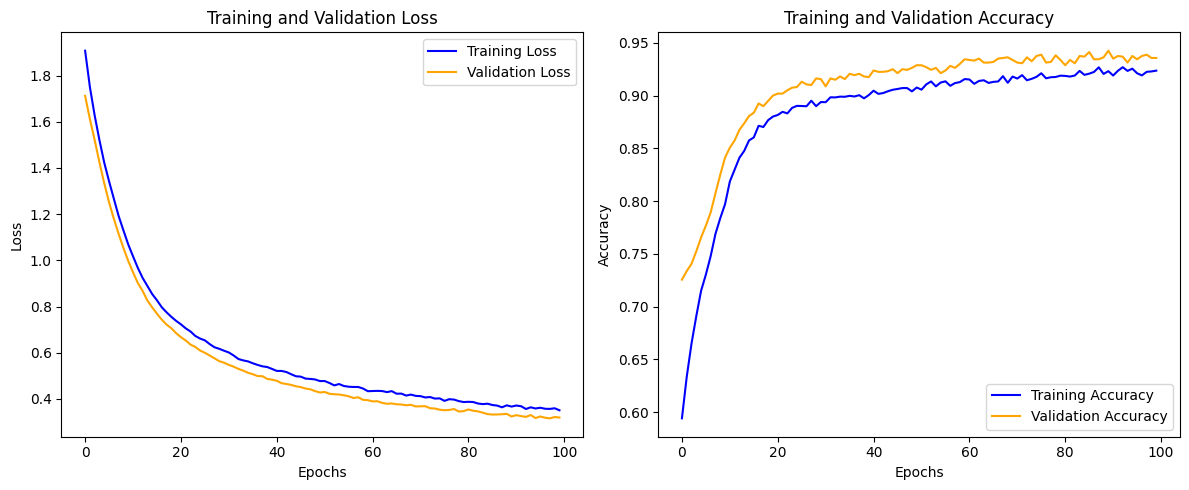

Test Loss: 0.4231463670730591
Test Accuracy: 0.8995000123977661


In [63]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming X_train, X_test, X_val, and y_train, y_test, y_val are already defined

# ———————— 1) Build the Neural Network Model ————————
model = Sequential()

# Input layer with 64 neurons and ReLU activation
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# First hidden layer with 32 neurons, ReLU activation, and BatchNormalization
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())

# Second hidden layer with 32 neurons, ReLU activation, and BatchNormalization
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())

# Dropout layer to prevent overfitting
model.add(Dropout(0.3))

# Output layer with 1 neuron and Sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping and Learning Rate Scheduler Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

#Train the Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot the Training and Validation Curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [64]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

X_train_np = X_train.to_numpy(dtype=np.float32)
X_test_np  = X_test .to_numpy(dtype=np.float32)
col_means  = np.nanmean(X_train_np, axis=0)
X_train_np = np.nan_to_num(X_train_np, nan=col_means)
X_test_np  = np.nan_to_num(X_test_np,  nan=col_means)

y_train_np = y_train.to_numpy(dtype=np.int64)
y_test_np  = y_test .to_numpy(dtype=np.int64)

#  Base TabNet estimator
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tabnet = TabNetClassifier(
    device_name=device,
    optimizer_fn=torch.optim.Adam
)

#  Hyperparameter search space
param_dist = {
    'n_d':          [8, 16, 24],
    'n_a':          [8, 16, 24],
    'n_steps':      [3, 5, 7],
    'gamma':        [1.2, 1.3, 1.5],
    'lambda_sparse':[0.0001, 0.001, 0.01]
}

#  Set up RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=tabnet,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=1
)

#  Run the search
rs.fit(
    X_train_np, y_train_np,
    max_epochs=20,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    drop_last=False
)

#  Store in best_estimators
best_tabnet = rs.best_estimator_
best_estimators['TabNet'] = best_tabnet
print("Best TabNet params:", rs.best_params_)

#  Evaluate tthe tuned TabNet
y_pred  = best_tabnet.predict(X_test_np)
y_proba = best_tabnet.predict_proba(X_test_np)[:, 1]
print(f"\nTabNet — Accuracy:  {accuracy_score(y_test_np, y_pred):.4f}")
print(f"TabNet — ROC AUC:    {roc_auc_score(y_test_np, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred, zero_division=0))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.65602 |  0:00:00s
epoch 1  | loss: 0.44628 |  0:00:01s
epoch 2  | loss: 0.37144 |  0:00:01s
epoch 3  | loss: 0.34689 |  0:00:02s
epoch 4  | loss: 0.32203 |  0:00:03s
epoch 5  | loss: 0.3123  |  0:00:03s
epoch 6  | loss: 0.31744 |  0:00:04s
epoch 7  | loss: 0.30536 |  0:00:04s
epoch 8  | loss: 0.30439 |  0:00:05s
epoch 9  | loss: 0.31207 |  0:00:06s
epoch 10 | loss: 0.28644 |  0:00:06s
epoch 11 | loss: 0.27475 |  0:00:07s
epoch 12 | loss: 0.27255 |  0:00:08s
epoch 13 | loss: 0.27486 |  0:00:09s
epoch 14 | loss: 0.2643  |  0:00:10s
epoch 15 | loss: 0.26601 |  0:00:10s
epoch 16 | loss: 0.26836 |  0:00:11s
epoch 17 | loss: 0.25991 |  0:00:12s
epoch 18 | loss: 0.25615 |  0:00:12s
epoch 19 | loss: 0.25807 |  0:00:13s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.67899 |  0:00:00s
epoch 1  | loss: 0.45166 |  0:00:01s
epoch 2  | loss: 0.37448 |  0:00:01s
epoch 3  | loss: 0.34879 |  0:00:02s
epoch 4  | loss: 0.34025 |  0:00:03s
epoch 5  | loss: 0.32158 |  0:00:03s
epoch 6  | loss: 0.31581 |  0:00:04s
epoch 7  | loss: 0.29762 |  0:00:04s
epoch 8  | loss: 0.29147 |  0:00:05s
epoch 9  | loss: 0.30035 |  0:00:06s
epoch 10 | loss: 0.27834 |  0:00:06s
epoch 11 | loss: 0.26374 |  0:00:07s
epoch 12 | loss: 0.25933 |  0:00:08s
epoch 13 | loss: 0.25051 |  0:00:09s
epoch 14 | loss: 0.24923 |  0:00:10s
epoch 15 | loss: 0.25138 |  0:00:10s
epoch 16 | loss: 0.25368 |  0:00:11s
epoch 17 | loss: 0.24246 |  0:00:12s
epoch 18 | loss: 0.24732 |  0:00:12s
epoch 19 | loss: 0.24332 |  0:00:13s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.64854 |  0:00:00s
epoch 1  | loss: 0.49341 |  0:00:01s
epoch 2  | loss: 0.39037 |  0:00:01s
epoch 3  | loss: 0.34305 |  0:00:02s
epoch 4  | loss: 0.31879 |  0:00:03s
epoch 5  | loss: 0.30359 |  0:00:03s
epoch 6  | loss: 0.30075 |  0:00:04s
epoch 7  | loss: 0.29665 |  0:00:04s
epoch 8  | loss: 0.28482 |  0:00:05s
epoch 9  | loss: 0.28089 |  0:00:06s
epoch 10 | loss: 0.26408 |  0:00:06s
epoch 11 | loss: 0.26768 |  0:00:07s
epoch 12 | loss: 0.26262 |  0:00:08s
epoch 13 | loss: 0.25184 |  0:00:09s
epoch 14 | loss: 0.26441 |  0:00:10s
epoch 15 | loss: 0.24753 |  0:00:11s
epoch 16 | loss: 0.24558 |  0:00:11s
epoch 17 | loss: 0.24294 |  0:00:12s
epoch 18 | loss: 0.24549 |  0:00:12s
epoch 19 | loss: 0.24254 |  0:00:13s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.66968 |  0:00:00s
epoch 1  | loss: 0.42462 |  0:00:01s
epoch 2  | loss: 0.36184 |  0:00:01s
epoch 3  | loss: 0.34799 |  0:00:02s
epoch 4  | loss: 0.32463 |  0:00:02s
epoch 5  | loss: 0.31675 |  0:00:03s
epoch 6  | loss: 0.30708 |  0:00:03s
epoch 7  | loss: 0.29628 |  0:00:04s
epoch 8  | loss: 0.29823 |  0:00:04s
epoch 9  | loss: 0.29416 |  0:00:05s
epoch 10 | loss: 0.28458 |  0:00:05s
epoch 11 | loss: 0.27867 |  0:00:06s
epoch 12 | loss: 0.27165 |  0:00:07s
epoch 13 | loss: 0.27351 |  0:00:08s
epoch 14 | loss: 0.26974 |  0:00:08s
epoch 15 | loss: 0.26546 |  0:00:09s
epoch 16 | loss: 0.25227 |  0:00:10s
epoch 17 | loss: 0.25507 |  0:00:10s
epoch 18 | loss: 0.265   |  0:00:11s
epoch 19 | loss: 0.25565 |  0:00:11s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.66428 |  0:00:00s
epoch 1  | loss: 0.43575 |  0:00:01s
epoch 2  | loss: 0.36564 |  0:00:01s
epoch 3  | loss: 0.3381  |  0:00:02s
epoch 4  | loss: 0.32723 |  0:00:02s
epoch 5  | loss: 0.32266 |  0:00:03s
epoch 6  | loss: 0.31725 |  0:00:03s
epoch 7  | loss: 0.31432 |  0:00:04s
epoch 8  | loss: 0.3061  |  0:00:04s
epoch 9  | loss: 0.30774 |  0:00:05s
epoch 10 | loss: 0.29231 |  0:00:05s
epoch 11 | loss: 0.29116 |  0:00:06s
epoch 12 | loss: 0.28423 |  0:00:07s
epoch 13 | loss: 0.28346 |  0:00:07s
epoch 14 | loss: 0.28463 |  0:00:08s
epoch 15 | loss: 0.27285 |  0:00:09s
epoch 16 | loss: 0.27343 |  0:00:09s
epoch 17 | loss: 0.27072 |  0:00:10s
epoch 18 | loss: 0.26379 |  0:00:11s
epoch 19 | loss: 0.26533 |  0:00:12s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.66998 |  0:00:00s
epoch 1  | loss: 0.50072 |  0:00:01s
epoch 2  | loss: 0.45708 |  0:00:01s
epoch 3  | loss: 0.4163  |  0:00:02s
epoch 4  | loss: 0.38087 |  0:00:02s
epoch 5  | loss: 0.36924 |  0:00:03s
epoch 6  | loss: 0.33493 |  0:00:03s
epoch 7  | loss: 0.31538 |  0:00:04s
epoch 8  | loss: 0.29386 |  0:00:05s
epoch 9  | loss: 0.28684 |  0:00:05s
epoch 10 | loss: 0.28461 |  0:00:06s
epoch 11 | loss: 0.275   |  0:00:06s
epoch 12 | loss: 0.27648 |  0:00:07s
epoch 13 | loss: 0.26574 |  0:00:07s
epoch 14 | loss: 0.26529 |  0:00:08s
epoch 15 | loss: 0.26152 |  0:00:08s
epoch 16 | loss: 0.27247 |  0:00:09s
epoch 17 | loss: 0.26671 |  0:00:10s
epoch 18 | loss: 0.25669 |  0:00:11s
epoch 19 | loss: 0.26754 |  0:00:12s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.07589 |  0:00:01s
epoch 1  | loss: 0.49803 |  0:00:02s
epoch 2  | loss: 0.40637 |  0:00:03s
epoch 3  | loss: 0.43041 |  0:00:04s
epoch 4  | loss: 0.39593 |  0:00:05s
epoch 5  | loss: 0.38199 |  0:00:06s
epoch 6  | loss: 0.41448 |  0:00:08s
epoch 7  | loss: 0.36136 |  0:00:09s
epoch 8  | loss: 0.37193 |  0:00:10s
epoch 9  | loss: 0.35715 |  0:00:12s
epoch 10 | loss: 0.33721 |  0:00:13s
epoch 11 | loss: 0.33306 |  0:00:14s
epoch 12 | loss: 0.33646 |  0:00:15s
epoch 13 | loss: 0.33048 |  0:00:17s
epoch 14 | loss: 0.32948 |  0:00:18s
epoch 15 | loss: 0.32614 |  0:00:19s
epoch 16 | loss: 0.33168 |  0:00:20s
epoch 17 | loss: 0.326   |  0:00:21s
epoch 18 | loss: 0.32353 |  0:00:22s
epoch 19 | loss: 0.32413 |  0:00:24s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.16112 |  0:00:01s
epoch 1  | loss: 0.59571 |  0:00:02s
epoch 2  | loss: 0.49583 |  0:00:03s
epoch 3  | loss: 0.46813 |  0:00:05s
epoch 4  | loss: 0.41527 |  0:00:06s
epoch 5  | loss: 0.38158 |  0:00:07s
epoch 6  | loss: 0.38833 |  0:00:08s
epoch 7  | loss: 0.36517 |  0:00:09s
epoch 8  | loss: 0.35196 |  0:00:10s
epoch 9  | loss: 0.34948 |  0:00:11s
epoch 10 | loss: 0.33198 |  0:00:13s
epoch 11 | loss: 0.3171  |  0:00:15s
epoch 12 | loss: 0.31564 |  0:00:16s
epoch 13 | loss: 0.31623 |  0:00:17s
epoch 14 | loss: 0.30919 |  0:00:18s
epoch 15 | loss: 0.30053 |  0:00:19s
epoch 16 | loss: 0.29945 |  0:00:20s
epoch 17 | loss: 0.29582 |  0:00:22s
epoch 18 | loss: 0.29598 |  0:00:23s
epoch 19 | loss: 0.28067 |  0:00:24s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.14058 |  0:00:01s
epoch 1  | loss: 0.5977  |  0:00:03s
epoch 2  | loss: 0.51568 |  0:00:04s
epoch 3  | loss: 0.47574 |  0:00:05s
epoch 4  | loss: 0.45587 |  0:00:06s
epoch 5  | loss: 0.42017 |  0:00:07s
epoch 6  | loss: 0.40445 |  0:00:08s
epoch 7  | loss: 0.36499 |  0:00:10s
epoch 8  | loss: 0.36225 |  0:00:11s
epoch 9  | loss: 0.37235 |  0:00:12s
epoch 10 | loss: 0.34925 |  0:00:13s
epoch 11 | loss: 0.32933 |  0:00:15s
epoch 12 | loss: 0.32217 |  0:00:17s
epoch 13 | loss: 0.31679 |  0:00:18s
epoch 14 | loss: 0.30211 |  0:00:19s
epoch 15 | loss: 0.29533 |  0:00:20s
epoch 16 | loss: 0.29014 |  0:00:21s
epoch 17 | loss: 0.2886  |  0:00:22s
epoch 18 | loss: 0.2831  |  0:00:23s
epoch 19 | loss: 0.29856 |  0:00:24s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.85647 |  0:00:00s
epoch 1  | loss: 0.57046 |  0:00:02s
epoch 2  | loss: 0.43068 |  0:00:03s
epoch 3  | loss: 0.43428 |  0:00:05s
epoch 4  | loss: 0.41056 |  0:00:05s
epoch 5  | loss: 0.39144 |  0:00:06s
epoch 6  | loss: 0.37541 |  0:00:07s
epoch 7  | loss: 0.37918 |  0:00:08s
epoch 8  | loss: 0.37619 |  0:00:09s
epoch 9  | loss: 0.37429 |  0:00:10s
epoch 10 | loss: 0.35044 |  0:00:11s
epoch 11 | loss: 0.31697 |  0:00:13s
epoch 12 | loss: 0.31672 |  0:00:15s
epoch 13 | loss: 0.30996 |  0:00:17s
epoch 14 | loss: 0.29726 |  0:00:19s
epoch 15 | loss: 0.294   |  0:00:21s
epoch 16 | loss: 0.28999 |  0:00:22s
epoch 17 | loss: 0.29121 |  0:00:23s
epoch 18 | loss: 0.28451 |  0:00:24s
epoch 19 | loss: 0.28214 |  0:00:25s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.82181 |  0:00:00s
epoch 1  | loss: 0.5944  |  0:00:01s
epoch 2  | loss: 0.57997 |  0:00:02s
epoch 3  | loss: 0.53763 |  0:00:03s
epoch 4  | loss: 0.4537  |  0:00:04s
epoch 5  | loss: 0.40043 |  0:00:05s
epoch 6  | loss: 0.37122 |  0:00:06s
epoch 7  | loss: 0.36839 |  0:00:07s
epoch 8  | loss: 0.35002 |  0:00:08s
epoch 9  | loss: 0.34611 |  0:00:09s
epoch 10 | loss: 0.3418  |  0:00:10s
epoch 11 | loss: 0.33659 |  0:00:11s
epoch 12 | loss: 0.332   |  0:00:12s
epoch 13 | loss: 0.33547 |  0:00:13s
epoch 14 | loss: 0.34128 |  0:00:14s
epoch 15 | loss: 0.32949 |  0:00:15s
epoch 16 | loss: 0.33065 |  0:00:15s
epoch 17 | loss: 0.32734 |  0:00:16s
epoch 18 | loss: 0.33087 |  0:00:17s
epoch 19 | loss: 0.31282 |  0:00:18s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.82034 |  0:00:00s
epoch 1  | loss: 0.59773 |  0:00:01s
epoch 2  | loss: 0.51619 |  0:00:02s
epoch 3  | loss: 0.46491 |  0:00:04s
epoch 4  | loss: 0.49085 |  0:00:05s
epoch 5  | loss: 0.46075 |  0:00:06s
epoch 6  | loss: 0.43611 |  0:00:07s
epoch 7  | loss: 0.39937 |  0:00:07s
epoch 8  | loss: 0.39234 |  0:00:08s
epoch 9  | loss: 0.38243 |  0:00:09s
epoch 10 | loss: 0.37188 |  0:00:10s
epoch 11 | loss: 0.35278 |  0:00:11s
epoch 12 | loss: 0.34321 |  0:00:12s
epoch 13 | loss: 0.35861 |  0:00:13s
epoch 14 | loss: 0.34538 |  0:00:13s
epoch 15 | loss: 0.33907 |  0:00:14s
epoch 16 | loss: 0.3323  |  0:00:15s
epoch 17 | loss: 0.33008 |  0:00:17s
epoch 18 | loss: 0.31157 |  0:00:18s
epoch 19 | loss: 0.31483 |  0:00:19s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.77765 |  0:00:00s
epoch 1  | loss: 0.53153 |  0:00:01s
epoch 2  | loss: 0.46119 |  0:00:02s
epoch 3  | loss: 0.42928 |  0:00:03s
epoch 4  | loss: 0.39424 |  0:00:04s
epoch 5  | loss: 0.3635  |  0:00:05s
epoch 6  | loss: 0.36224 |  0:00:06s
epoch 7  | loss: 0.3513  |  0:00:07s
epoch 8  | loss: 0.33822 |  0:00:07s
epoch 9  | loss: 0.3327  |  0:00:08s
epoch 10 | loss: 0.33448 |  0:00:10s
epoch 11 | loss: 0.31727 |  0:00:11s
epoch 12 | loss: 0.30588 |  0:00:12s
epoch 13 | loss: 0.30905 |  0:00:13s
epoch 14 | loss: 0.30703 |  0:00:14s
epoch 15 | loss: 0.30047 |  0:00:15s
epoch 16 | loss: 0.28478 |  0:00:15s
epoch 17 | loss: 0.28865 |  0:00:16s
epoch 18 | loss: 0.2842  |  0:00:17s
epoch 19 | loss: 0.28297 |  0:00:18s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.72997 |  0:00:00s
epoch 1  | loss: 0.50831 |  0:00:01s
epoch 2  | loss: 0.42455 |  0:00:02s
epoch 3  | loss: 0.40836 |  0:00:03s
epoch 4  | loss: 0.40135 |  0:00:04s
epoch 5  | loss: 0.3741  |  0:00:06s
epoch 6  | loss: 0.37955 |  0:00:07s
epoch 7  | loss: 0.38355 |  0:00:08s
epoch 8  | loss: 0.38482 |  0:00:08s
epoch 9  | loss: 0.3727  |  0:00:09s
epoch 10 | loss: 0.36842 |  0:00:10s
epoch 11 | loss: 0.36251 |  0:00:11s
epoch 12 | loss: 0.36795 |  0:00:12s
epoch 13 | loss: 0.35831 |  0:00:13s
epoch 14 | loss: 0.35798 |  0:00:14s
epoch 15 | loss: 0.34409 |  0:00:14s
epoch 16 | loss: 0.34534 |  0:00:15s
epoch 17 | loss: 0.33713 |  0:00:16s
epoch 18 | loss: 0.33145 |  0:00:17s
epoch 19 | loss: 0.32374 |  0:00:18s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.71292 |  0:00:00s
epoch 1  | loss: 0.48349 |  0:00:01s
epoch 2  | loss: 0.43089 |  0:00:02s
epoch 3  | loss: 0.39425 |  0:00:03s
epoch 4  | loss: 0.37902 |  0:00:04s
epoch 5  | loss: 0.3844  |  0:00:05s
epoch 6  | loss: 0.36667 |  0:00:06s
epoch 7  | loss: 0.379   |  0:00:06s
epoch 8  | loss: 0.35998 |  0:00:07s
epoch 9  | loss: 0.35427 |  0:00:08s
epoch 10 | loss: 0.36763 |  0:00:09s
epoch 11 | loss: 0.36456 |  0:00:10s
epoch 12 | loss: 0.35498 |  0:00:11s
epoch 13 | loss: 0.35764 |  0:00:12s
epoch 14 | loss: 0.35024 |  0:00:13s
epoch 15 | loss: 0.35146 |  0:00:14s
epoch 16 | loss: 0.33547 |  0:00:15s
epoch 17 | loss: 0.33528 |  0:00:16s
epoch 18 | loss: 0.32166 |  0:00:17s
epoch 19 | loss: 0.32686 |  0:00:18s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.90116 |  0:00:00s
epoch 1  | loss: 0.63275 |  0:00:01s
epoch 2  | loss: 0.53831 |  0:00:02s
epoch 3  | loss: 0.45174 |  0:00:03s
epoch 4  | loss: 0.40724 |  0:00:04s
epoch 5  | loss: 0.39025 |  0:00:05s
epoch 6  | loss: 0.36582 |  0:00:06s
epoch 7  | loss: 0.34125 |  0:00:07s
epoch 8  | loss: 0.33344 |  0:00:08s
epoch 9  | loss: 0.32222 |  0:00:09s
epoch 10 | loss: 0.3128  |  0:00:10s
epoch 11 | loss: 0.30752 |  0:00:11s
epoch 12 | loss: 0.30527 |  0:00:12s
epoch 13 | loss: 0.30222 |  0:00:13s
epoch 14 | loss: 0.29897 |  0:00:13s
epoch 15 | loss: 0.31079 |  0:00:14s
epoch 16 | loss: 0.30464 |  0:00:15s
epoch 17 | loss: 0.29028 |  0:00:16s
epoch 18 | loss: 0.28994 |  0:00:17s
epoch 19 | loss: 0.28596 |  0:00:17s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.84192 |  0:00:01s
epoch 1  | loss: 0.61916 |  0:00:02s
epoch 2  | loss: 0.54083 |  0:00:03s
epoch 3  | loss: 0.47307 |  0:00:04s
epoch 4  | loss: 0.43937 |  0:00:05s
epoch 5  | loss: 0.40415 |  0:00:05s
epoch 6  | loss: 0.37646 |  0:00:06s
epoch 7  | loss: 0.35924 |  0:00:07s
epoch 8  | loss: 0.36125 |  0:00:08s
epoch 9  | loss: 0.35021 |  0:00:09s
epoch 10 | loss: 0.33668 |  0:00:10s
epoch 11 | loss: 0.3347  |  0:00:10s
epoch 12 | loss: 0.32648 |  0:00:11s
epoch 13 | loss: 0.31435 |  0:00:12s
epoch 14 | loss: 0.30902 |  0:00:13s
epoch 15 | loss: 0.30085 |  0:00:14s
epoch 16 | loss: 0.29617 |  0:00:15s
epoch 17 | loss: 0.29343 |  0:00:16s
epoch 18 | loss: 0.29151 |  0:00:17s
epoch 19 | loss: 0.29406 |  0:00:18s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.88179 |  0:00:00s
epoch 1  | loss: 0.54569 |  0:00:01s
epoch 2  | loss: 0.47426 |  0:00:02s
epoch 3  | loss: 0.46993 |  0:00:03s
epoch 4  | loss: 0.41875 |  0:00:04s
epoch 5  | loss: 0.39383 |  0:00:04s
epoch 6  | loss: 0.38188 |  0:00:05s
epoch 7  | loss: 0.37285 |  0:00:06s
epoch 8  | loss: 0.36925 |  0:00:07s
epoch 9  | loss: 0.35473 |  0:00:08s
epoch 10 | loss: 0.35843 |  0:00:09s
epoch 11 | loss: 0.3342  |  0:00:10s
epoch 12 | loss: 0.33352 |  0:00:11s
epoch 13 | loss: 0.32283 |  0:00:12s
epoch 14 | loss: 0.31608 |  0:00:13s
epoch 15 | loss: 0.31015 |  0:00:14s
epoch 16 | loss: 0.30258 |  0:00:14s
epoch 17 | loss: 0.30953 |  0:00:15s
epoch 18 | loss: 0.31064 |  0:00:16s
epoch 19 | loss: 0.30545 |  0:00:17s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.8053  |  0:00:01s
epoch 1  | loss: 0.50992 |  0:00:02s
epoch 2  | loss: 0.44849 |  0:00:03s
epoch 3  | loss: 0.47145 |  0:00:05s
epoch 4  | loss: 0.41243 |  0:00:06s
epoch 5  | loss: 0.3991  |  0:00:08s
epoch 6  | loss: 0.37598 |  0:00:09s
epoch 7  | loss: 0.36709 |  0:00:10s
epoch 8  | loss: 0.37618 |  0:00:11s
epoch 9  | loss: 0.37374 |  0:00:12s
epoch 10 | loss: 0.36427 |  0:00:14s
epoch 11 | loss: 0.34914 |  0:00:15s
epoch 12 | loss: 0.35533 |  0:00:16s
epoch 13 | loss: 0.34737 |  0:00:17s
epoch 14 | loss: 0.35116 |  0:00:19s
epoch 15 | loss: 0.3643  |  0:00:21s
epoch 16 | loss: 0.33837 |  0:00:22s
epoch 17 | loss: 0.33074 |  0:00:23s
epoch 18 | loss: 0.31345 |  0:00:24s
epoch 19 | loss: 0.31427 |  0:00:25s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.81459 |  0:00:01s
epoch 1  | loss: 0.56029 |  0:00:02s
epoch 2  | loss: 0.53405 |  0:00:03s
epoch 3  | loss: 0.51167 |  0:00:05s
epoch 4  | loss: 0.41516 |  0:00:06s
epoch 5  | loss: 0.48772 |  0:00:08s
epoch 6  | loss: 0.41395 |  0:00:09s
epoch 7  | loss: 0.38365 |  0:00:10s
epoch 8  | loss: 0.35592 |  0:00:11s
epoch 9  | loss: 0.35657 |  0:00:12s
epoch 10 | loss: 0.37326 |  0:00:14s
epoch 11 | loss: 0.37578 |  0:00:15s
epoch 12 | loss: 0.35258 |  0:00:16s
epoch 13 | loss: 0.35057 |  0:00:17s
epoch 14 | loss: 0.34151 |  0:00:19s
epoch 15 | loss: 0.34713 |  0:00:20s
epoch 16 | loss: 0.33838 |  0:00:22s
epoch 17 | loss: 0.3298  |  0:00:23s
epoch 18 | loss: 0.31845 |  0:00:24s
epoch 19 | loss: 0.31418 |  0:00:25s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73059 |  0:00:01s
epoch 1  | loss: 0.57454 |  0:00:02s
epoch 2  | loss: 0.54726 |  0:00:03s
epoch 3  | loss: 0.47789 |  0:00:04s
epoch 4  | loss: 0.42544 |  0:00:06s
epoch 5  | loss: 0.42062 |  0:00:08s
epoch 6  | loss: 0.42065 |  0:00:09s
epoch 7  | loss: 0.4208  |  0:00:10s
epoch 8  | loss: 0.39367 |  0:00:12s
epoch 9  | loss: 0.37957 |  0:00:14s
epoch 10 | loss: 0.38728 |  0:00:15s
epoch 11 | loss: 0.3623  |  0:00:16s
epoch 12 | loss: 0.3504  |  0:00:17s
epoch 13 | loss: 0.36564 |  0:00:18s
epoch 14 | loss: 0.3509  |  0:00:20s
epoch 15 | loss: 0.35462 |  0:00:22s
epoch 16 | loss: 0.34767 |  0:00:23s
epoch 17 | loss: 0.33844 |  0:00:24s
epoch 18 | loss: 0.36017 |  0:00:25s
epoch 19 | loss: 0.34342 |  0:00:26s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.64754 |  0:00:00s
epoch 1  | loss: 0.49194 |  0:00:01s
epoch 2  | loss: 0.39939 |  0:00:01s
epoch 3  | loss: 0.36135 |  0:00:02s
epoch 4  | loss: 0.34591 |  0:00:02s
epoch 5  | loss: 0.33773 |  0:00:03s
epoch 6  | loss: 0.32874 |  0:00:03s
epoch 7  | loss: 0.31595 |  0:00:04s
epoch 8  | loss: 0.31373 |  0:00:05s
epoch 9  | loss: 0.3015  |  0:00:06s
epoch 10 | loss: 0.29364 |  0:00:07s
epoch 11 | loss: 0.29032 |  0:00:08s
epoch 12 | loss: 0.28197 |  0:00:08s
epoch 13 | loss: 0.27287 |  0:00:09s
epoch 14 | loss: 0.27381 |  0:00:09s
epoch 15 | loss: 0.28002 |  0:00:10s
epoch 16 | loss: 0.27027 |  0:00:10s
epoch 17 | loss: 0.26024 |  0:00:11s
epoch 18 | loss: 0.25354 |  0:00:12s
epoch 19 | loss: 0.25348 |  0:00:12s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.60419 |  0:00:00s
epoch 1  | loss: 0.44886 |  0:00:01s
epoch 2  | loss: 0.38579 |  0:00:01s
epoch 3  | loss: 0.37153 |  0:00:02s
epoch 4  | loss: 0.34699 |  0:00:02s
epoch 5  | loss: 0.32971 |  0:00:03s
epoch 6  | loss: 0.32572 |  0:00:04s
epoch 7  | loss: 0.31893 |  0:00:05s
epoch 8  | loss: 0.30731 |  0:00:05s
epoch 9  | loss: 0.31111 |  0:00:06s
epoch 10 | loss: 0.29834 |  0:00:07s
epoch 11 | loss: 0.30441 |  0:00:08s
epoch 12 | loss: 0.3123  |  0:00:09s
epoch 13 | loss: 0.29536 |  0:00:09s
epoch 14 | loss: 0.28591 |  0:00:10s
epoch 15 | loss: 0.28361 |  0:00:10s
epoch 16 | loss: 0.2758  |  0:00:11s
epoch 17 | loss: 0.27696 |  0:00:11s
epoch 18 | loss: 0.27342 |  0:00:12s
epoch 19 | loss: 0.2683  |  0:00:13s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.55974 |  0:00:00s
epoch 1  | loss: 0.38596 |  0:00:01s
epoch 2  | loss: 0.34207 |  0:00:01s
epoch 3  | loss: 0.31385 |  0:00:02s
epoch 4  | loss: 0.30437 |  0:00:03s
epoch 5  | loss: 0.29078 |  0:00:03s
epoch 6  | loss: 0.28705 |  0:00:04s
epoch 7  | loss: 0.27605 |  0:00:04s
epoch 8  | loss: 0.27356 |  0:00:05s
epoch 9  | loss: 0.28445 |  0:00:06s
epoch 10 | loss: 0.27028 |  0:00:07s
epoch 11 | loss: 0.26607 |  0:00:08s
epoch 12 | loss: 0.25953 |  0:00:08s
epoch 13 | loss: 0.26322 |  0:00:09s
epoch 14 | loss: 0.25291 |  0:00:09s
epoch 15 | loss: 0.25218 |  0:00:10s
epoch 16 | loss: 0.24568 |  0:00:11s
epoch 17 | loss: 0.24278 |  0:00:11s
epoch 18 | loss: 0.23573 |  0:00:12s
epoch 19 | loss: 0.24537 |  0:00:12s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.73896 |  0:00:00s
epoch 1  | loss: 0.47785 |  0:00:01s
epoch 2  | loss: 0.36857 |  0:00:01s
epoch 3  | loss: 0.33495 |  0:00:02s
epoch 4  | loss: 0.32017 |  0:00:02s
epoch 5  | loss: 0.29928 |  0:00:03s
epoch 6  | loss: 0.29445 |  0:00:03s
epoch 7  | loss: 0.28374 |  0:00:04s
epoch 8  | loss: 0.27523 |  0:00:04s
epoch 9  | loss: 0.2701  |  0:00:05s
epoch 10 | loss: 0.26104 |  0:00:05s
epoch 11 | loss: 0.26228 |  0:00:06s
epoch 12 | loss: 0.26659 |  0:00:07s
epoch 13 | loss: 0.25906 |  0:00:08s
epoch 14 | loss: 0.24822 |  0:00:09s
epoch 15 | loss: 0.25773 |  0:00:09s
epoch 16 | loss: 0.25649 |  0:00:10s
epoch 17 | loss: 0.24106 |  0:00:10s
epoch 18 | loss: 0.23624 |  0:00:11s
epoch 19 | loss: 0.22809 |  0:00:11s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.65468 |  0:00:00s
epoch 1  | loss: 0.41859 |  0:00:01s
epoch 2  | loss: 0.36111 |  0:00:01s
epoch 3  | loss: 0.35114 |  0:00:02s
epoch 4  | loss: 0.33829 |  0:00:02s
epoch 5  | loss: 0.32859 |  0:00:03s
epoch 6  | loss: 0.31097 |  0:00:03s
epoch 7  | loss: 0.30701 |  0:00:04s
epoch 8  | loss: 0.29381 |  0:00:04s
epoch 9  | loss: 0.2954  |  0:00:05s
epoch 10 | loss: 0.28697 |  0:00:05s
epoch 11 | loss: 0.28697 |  0:00:06s
epoch 12 | loss: 0.27603 |  0:00:07s
epoch 13 | loss: 0.2666  |  0:00:07s
epoch 14 | loss: 0.26358 |  0:00:08s
epoch 15 | loss: 0.25844 |  0:00:09s
epoch 16 | loss: 0.25858 |  0:00:10s
epoch 17 | loss: 0.26391 |  0:00:10s
epoch 18 | loss: 0.25602 |  0:00:11s
epoch 19 | loss: 0.24717 |  0:00:11s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.70327 |  0:00:00s
epoch 1  | loss: 0.45246 |  0:00:01s
epoch 2  | loss: 0.38444 |  0:00:01s
epoch 3  | loss: 0.36115 |  0:00:02s
epoch 4  | loss: 0.33701 |  0:00:02s
epoch 5  | loss: 0.31395 |  0:00:03s
epoch 6  | loss: 0.31209 |  0:00:03s
epoch 7  | loss: 0.32524 |  0:00:04s
epoch 8  | loss: 0.31362 |  0:00:04s
epoch 9  | loss: 0.30803 |  0:00:05s
epoch 10 | loss: 0.3046  |  0:00:06s
epoch 11 | loss: 0.29798 |  0:00:06s
epoch 12 | loss: 0.30028 |  0:00:07s
epoch 13 | loss: 0.2933  |  0:00:07s
epoch 14 | loss: 0.28482 |  0:00:08s
epoch 15 | loss: 0.28521 |  0:00:09s
epoch 16 | loss: 0.27879 |  0:00:09s
epoch 17 | loss: 0.27549 |  0:00:10s
epoch 18 | loss: 0.27326 |  0:00:11s
epoch 19 | loss: 0.2696  |  0:00:11s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.80313 |  0:00:01s
epoch 1  | loss: 0.5248  |  0:00:02s
epoch 2  | loss: 0.46227 |  0:00:03s
epoch 3  | loss: 0.44587 |  0:00:04s
epoch 4  | loss: 0.42315 |  0:00:05s
epoch 5  | loss: 0.4342  |  0:00:06s
epoch 6  | loss: 0.39785 |  0:00:07s
epoch 7  | loss: 0.41083 |  0:00:08s
epoch 8  | loss: 0.4025  |  0:00:09s
epoch 9  | loss: 0.39023 |  0:00:11s
epoch 10 | loss: 0.38953 |  0:00:12s
epoch 11 | loss: 0.36903 |  0:00:13s
epoch 12 | loss: 0.36432 |  0:00:14s
epoch 13 | loss: 0.35367 |  0:00:15s
epoch 14 | loss: 0.34357 |  0:00:16s
epoch 15 | loss: 0.3368  |  0:00:17s
epoch 16 | loss: 0.33068 |  0:00:18s
epoch 17 | loss: 0.32648 |  0:00:19s
epoch 18 | loss: 0.33414 |  0:00:20s
epoch 19 | loss: 0.31891 |  0:00:21s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.84111 |  0:00:01s
epoch 1  | loss: 0.53699 |  0:00:02s
epoch 2  | loss: 0.46278 |  0:00:04s
epoch 3  | loss: 0.40433 |  0:00:05s
epoch 4  | loss: 0.41233 |  0:00:06s
epoch 5  | loss: 0.37519 |  0:00:07s
epoch 6  | loss: 0.36716 |  0:00:08s
epoch 7  | loss: 0.35511 |  0:00:09s
epoch 8  | loss: 0.3612  |  0:00:10s
epoch 9  | loss: 0.35552 |  0:00:11s
epoch 10 | loss: 0.3505  |  0:00:12s
epoch 11 | loss: 0.34153 |  0:00:14s
epoch 12 | loss: 0.34894 |  0:00:15s
epoch 13 | loss: 0.34266 |  0:00:17s
epoch 14 | loss: 0.33885 |  0:00:18s
epoch 15 | loss: 0.33683 |  0:00:19s
epoch 16 | loss: 0.34117 |  0:00:20s
epoch 17 | loss: 0.34021 |  0:00:21s
epoch 18 | loss: 0.34086 |  0:00:22s
epoch 19 | loss: 0.34216 |  0:00:23s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76678 |  0:00:01s
epoch 1  | loss: 0.54218 |  0:00:02s
epoch 2  | loss: 0.45122 |  0:00:03s
epoch 3  | loss: 0.45963 |  0:00:04s
epoch 4  | loss: 0.44853 |  0:00:05s
epoch 5  | loss: 0.43007 |  0:00:07s
epoch 6  | loss: 0.38786 |  0:00:08s
epoch 7  | loss: 0.37854 |  0:00:09s
epoch 8  | loss: 0.39231 |  0:00:10s
epoch 9  | loss: 0.3776  |  0:00:11s
epoch 10 | loss: 0.36006 |  0:00:12s
epoch 11 | loss: 0.3565  |  0:00:13s
epoch 12 | loss: 0.34541 |  0:00:14s
epoch 13 | loss: 0.33775 |  0:00:15s
epoch 14 | loss: 0.34997 |  0:00:16s
epoch 15 | loss: 0.34438 |  0:00:17s
epoch 16 | loss: 0.33693 |  0:00:19s
epoch 17 | loss: 0.33834 |  0:00:20s
epoch 18 | loss: 0.34079 |  0:00:21s
epoch 19 | loss: 0.32926 |  0:00:22s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.5928  |  0:00:00s
epoch 1  | loss: 0.39763 |  0:00:01s
epoch 2  | loss: 0.36238 |  0:00:02s
epoch 3  | loss: 0.34042 |  0:00:03s
epoch 4  | loss: 0.32612 |  0:00:04s
epoch 5  | loss: 0.31124 |  0:00:05s
epoch 6  | loss: 0.30925 |  0:00:06s
epoch 7  | loss: 0.30899 |  0:00:07s
epoch 8  | loss: 0.29308 |  0:00:08s
epoch 9  | loss: 0.28748 |  0:00:09s
epoch 10 | loss: 0.28745 |  0:00:10s
epoch 11 | loss: 0.28182 |  0:00:11s
epoch 12 | loss: 0.27096 |  0:00:12s
epoch 13 | loss: 0.27127 |  0:00:13s
epoch 14 | loss: 0.28433 |  0:00:14s
epoch 15 | loss: 0.27457 |  0:00:15s
epoch 16 | loss: 0.26389 |  0:00:15s
epoch 17 | loss: 0.26139 |  0:00:16s
epoch 18 | loss: 0.263   |  0:00:17s
epoch 19 | loss: 0.25663 |  0:00:18s
Best TabNet params: {'n_steps': 3, 'n_d': 24, 'n_a': 16, 'lambda_sparse': 0.01, 'gamma': 1.3}

TabNet — Accuracy:  0.9020
TabNet — ROC AUC:    0.9238

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.

In [65]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


#  Convert to NumPy arrays
X_train_np = X_train.to_numpy(dtype=np.float32)
X_test_np  = X_test .to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)
y_test_np  = y_test .to_numpy(dtype=np.int64)

#  Simple XGBoost training using default params
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train_np, y_train_np)

y_pred = xgb_model.predict(X_test_np)
print(">> XGBoost (default params) <<")
print("Accuracy:", accuracy_score(y_test_np, y_pred))
print(classification_report(y_test_np, y_pred))

#Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators':      [50, 100, 200],
    'max_depth':         [3, 5, 7],
    'learning_rate':     [0.01, 0.1, 0.2],
    'subsample':         [0.7, 1.0],
    'colsample_bytree':  [0.7, 1.0]
}

grid = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_np, y_train_np)
best_xgb = grid.best_estimator_
print("\nBest XGBoost params:", grid.best_params_)

# Store into best_estimators dictionary
best_estimators['XGBoost'] = best_xgb

#  Evaluate the tuned model
y_pred_best = best_xgb.predict(X_test_np)
print(">> XGBoost (tuned) <<")
print("Accuracy:", accuracy_score(y_test_np, y_pred_best))
print(classification_report(y_test_np, y_pred_best))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:44:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


>> XGBoost (default params) <<
Accuracy: 0.939
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       535
           1       0.94      0.97      0.96      1465

    accuracy                           0.94      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.94      0.94      0.94      2000

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:46:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best XGBoost params: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
>> XGBoost (tuned) <<
Accuracy: 0.943
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       535
           1       0.95      0.97      0.96      1465

    accuracy                           0.94      2000
   macro avg       0.94      0.92      0.93      2000
weighted avg       0.94      0.94      0.94      2000



In [66]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier



#  Define a small search space for LightGBM
param_dist = {
    'n_estimators':   [100, 200, 500],
    'num_leaves':     [31, 50, 100],
    'learning_rate':  [0.01, 0.05, 0.1],
    'max_depth':      [-1, 5, 10]
}

#  Set up RandomizedSearchCV
rs = RandomizedSearchCV(
    LGBMClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,           # 20 random combinations
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

#  Run the search on your training data
rs.fit(X_train, y_train)
print("Best hyperparameters for LightGBM:", rs.best_params_)

#  Extract and store the best estimator
best_lgb = rs.best_estimator_
best_estimators['LightGBM'] = best_lgb

#  Evaluate the optimized model on the hold-out set
y_pred = best_lgb.predict(X_test)
print(f"Optimized LightGBM — Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 5777, number of negative: 2223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722125 -> initscore=0.955027
[LightGBM] [Info] Start training from score 0.955027
Best hyperparameters for LightGBM: {'num_leaves': 31, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.05}
Optimized LightGBM — Accuracy: 0.9480
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       535
           1       0.95      0.98      0.97      1465

    accuracy                           0.95      2000
   macro avg       0.95      0.92      0.93      2000
weighted avg       0.95      0.95      0.95      2000



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:23:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 5777, number of negative: 2223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722125 -> initscore=0.955027
[LightGBM] [Info] Start training from score 0.955027


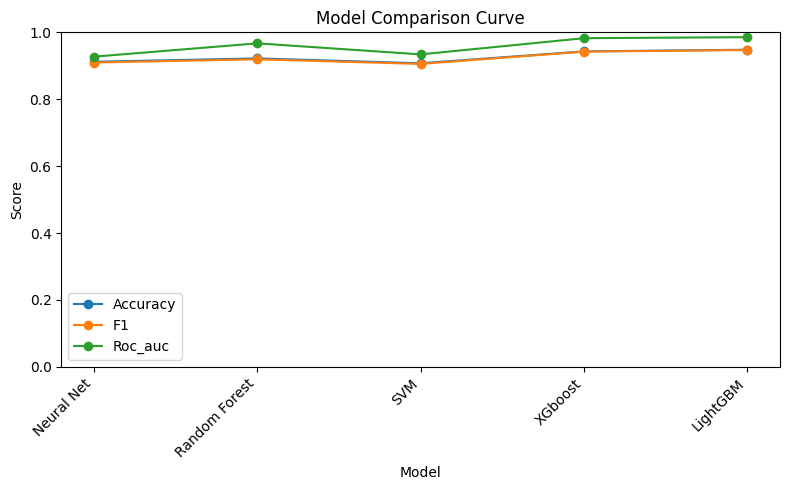

In [71]:
models = {
    'Neural Net':    best_estimators['Neural Network'],
    'Random Forest': best_estimators['Random Forest'],
    'SVM':           best_estimators['SVM'],
    'XGboost':       best_estimators['XGBoost'],
    'LightGBM':      best_estimators['LightGBM'],
   'TabNet':        best_estimators['TabNet']
}


records = []
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    rec = {
        'model':    name,
        'accuracy': accuracy_score(y_test,  y_pred),
        'f1':       f1_score(    y_test,  y_pred, average='weighted', zero_division=0)
    }
    if hasattr(m, "predict_proba"):
        rec['roc_auc'] = roc_auc_score(y_test, m.predict_proba(X_test)[:,1])
    records.append(rec)

df = pd.DataFrame(records).set_index('model')

#  Curve‐style line plot across models
plt.figure(figsize=(8,5))
for metric in ['accuracy','f1','roc_auc']:
    if metric in df:
        plt.plot(df.index, df[metric], marker='o', label=metric.capitalize())
plt.title('Model Comparison Curve')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0,1)
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:29:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 5777, number of negative: 2223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722125 -> initscore=0.955027
[LightGBM] [Info] Start training from score 0.955027
               accuracy  precision  recall        f1   roc_auc
model                                                         
Neural Net       0.9020   0.900268  0.9020  0.899786  0.918686
Random Forest    0.9240   0.924617  0.9240  0.921521  0.965034
SVM              0.9075   0.905985  0.9075  0.905580  0.934098
XGBoost          0.9430   0.942528  0.9430  0.942277  0.982523
LightGBM         0.9480   0.947937  0.9480  0.947125  0.985530


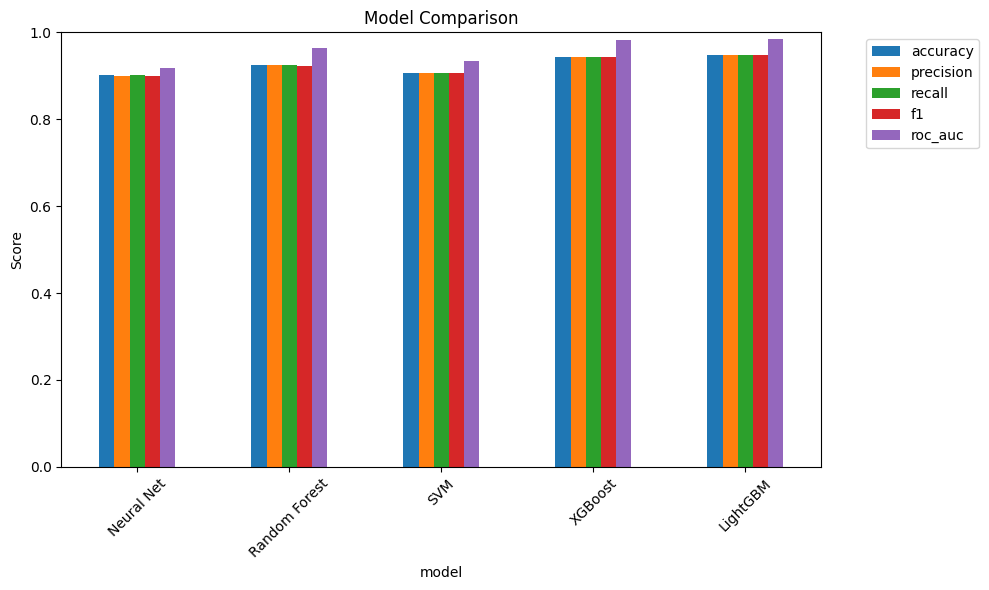

In [73]:
models = {
    'Neural Net':    best_estimators['Neural Network'],
    'Random Forest': best_estimators['Random Forest'],
    'SVM':           best_estimators['SVM'],
    'XGBoost':       best_estimators['XGBoost'],
    'LightGBM':      best_estimators['LightGBM']
}


records = []
for name, model in models.items():
    model.fit(X_train, y_train)   # retrain with best hyperparams
    y_pred = model.predict(X_test)
    rec = {
        'model':    name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision':precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall':   recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1':       f1_score(y_test, y_pred, average='weighted', zero_division=0),
    }
    if hasattr(model, "predict_proba"):
        rec['roc_auc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    records.append(rec)

#  Build DataFrame and print
df = pd.DataFrame(records).set_index('model')
print(df)

# Plot the comparison
df.plot(kind='bar', figsize=(10,6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


In [75]:
models = {
    'Neural Net':    best_estimators['Neural Network'],
    'Random Forest': best_estimators['Random Forest'],
    'SVM':           best_estimators['SVM'],
   'XGBoost':       best_estimators['XGBoost'],
    'LightGBM':      best_estimators['LightGBM'],
}

# Fit & evaluate on the sampled test set
records = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rec = {
        'model':    name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall':   recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1':       f1_score(y_test, y_pred, average='weighted', zero_division=0),
    }
    if hasattr(model, "predict_proba"):
        rec['roc_auc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    records.append(rec)

df_metrics = pd.DataFrame(records).set_index('model')
print(df_metrics)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:50:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 23284, number of negative: 8716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.727625 -> initscore=0.982606
[LightGBM] [Info] Start training from score 0.982606
               accuracy  precision    recall        f1   roc_auc
model                                                           
Neural Net     0.924375   0.923580  0.924375  0.923076  0.942618
Random Forest  0.937750   0.938706  0.937750  0.936067  0.981789
SVM            0.923375   0.923070  0.923375  0.921535  0.946469
XGBoost        0.948875   0.948514  0.948875  0.948579  0.986889
LightGBM       0.951375   0.951030  0.951375  0.951012 